In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [57]:
#defining triangular lattice
a=1
a_1=a*np.array([1,0,0])
a_2=a*np.array([1/2,np.sqrt(3)/2,0])
zhat=np.array([0,0,1])

Vol_real=np.dot(np.cross(a_1,a_2),zhat)
b_1=np.cross(a_2,zhat)*(2*np.pi)/Vol_real
b_2=np.cross(zhat,a_1)*(2*np.pi)/Vol_real
Vol_rec=np.dot(np.cross(b_1,b_2),zhat)
#print(np.dot(a_2,b_2),np.dot(a_1,b_1))

Np=20
n1=np.arange(-Np,Np+1)
n2=np.arange(-Np,Np+1)

a_1=a_1[0:2]
a_2=a_2[0:2]
b_1=b_1[0:2]
b_2=b_2[0:2]

In [58]:
#defining the parameter gamma in the static structure factor
def gamma(kx,ky):
    
    a_1=a*np.array([1,0])
    a_2=a*np.array([1/2,np.sqrt(3)/2])
    
    #creating lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=a_1*i+a_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=8)
    sorted_dist=sort(list(set(dist)) )
    nns=Recip_lat_arr[np.where( (dist<sorted_dist[2]) *( dist>0 ))[0]]
    e=0
    for nn in nns:
        e=e+exp(1j*(nn[0]*kx+nn[1]*ky))
    
    return np.real(e)



In [126]:

kx=np.linspace(-2*np.pi/a,2*np.pi/a,100)
ky=np.linspace(-2*np.pi/a,2*np.pi/a,100)

kxx, kyy =meshgrid(kx,ky)

def Sf(kx,ky,lam,T):
    return 1/(lam+(1/T)*gamma(kx,ky))

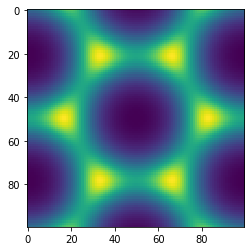

In [137]:
imshow(Sf(kxx,kyy,0.5,10))

In [62]:
#getting the first brilloin zone from the Voronoi decomp of the recipprocal lattice
#input: reciprocal lattice vectors
#output: Points that delimit the FBZ - 
#high symmetry points (for now just the triangular lattice will be implemented)
from scipy.spatial import Voronoi, voronoi_plot_2d
def FBZ_points(b_1,b_2):
    #creating reciprocal lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=b_1*i+b_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=10)
    sorted_dist=sort(list(set(dist)) )
    points=Recip_lat_arr[np.where(dist<sorted_dist[2])[0]]
    
    #getting the voronoi decomposition of the gamma point and the nearest neighbours
    vor = Voronoi(points)
    Vertices=(vor.vertices)
    
    #ordering the points counterclockwise in the -pi,pi range
    angles_list=list(np.arctan2(Vertices[:,1],Vertices[:,0]))
    Vertices_list=list(Vertices)
    
    #joint sorting the two lists for angles and vertices for convenience later. 
    # the linear plot routine requires the points to be in order
    # atan2 takes into acount quadrant to get the sign of the angle 
    angles_list, Vertices_list = (list(t) for t in zip(*sorted(zip(angles_list, Vertices_list))))
    
    ##getting the M points as the average of consecutive K- Kp points
    Edges_list=[]
    for i in range(len(Vertices_list)):
        Edges_list.append([(Vertices_list[i][0]+Vertices_list[i-1][0])/2,(Vertices_list[i][1]+Vertices_list[i-1][1])/2])
    
    Gamma=[0,0]
    K=Vertices_list[0::2]
    Kp=Vertices_list[1::2]
    M=Edges_list[0::2]
    Mp=Edges_list[1::2]
    
    return Vertices_list, Gamma, K, Kp, M, Mp

In [63]:
Vertices_list, Gamma, K, Kp, M, Mp=FBZ_points(b_1,b_2)

In [65]:
#creating reciprocal lattice preparing for k-point integration
Recip_lat=[]
for i in n1:
    for j in n2:
        point=b_1*i+b_2*j
        Recip_lat.append(point)


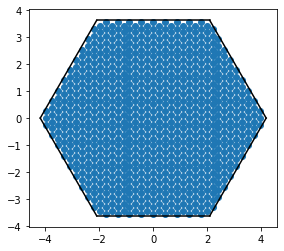

In [138]:

t=np.linspace(0,1,1000)
pol=np.array(Vertices_list).T
for i in range(6):
    plt.plot(pol[0,i%6]*(1-t)+t*pol[0,(i+1)%6],pol[1,i%6]*(1-t)+t*pol[1,(i+1)%6],c='k')

#generating k points
kx=np.linspace(-5*np.pi/a,5*np.pi/a,1000)
ky=np.linspace(-5*np.pi/a,5*np.pi/a,1000)

#square sampling
#kxx,kyy=np.meshgrid(kx,ky)

#Shrinking the reciprocal lattice
scale_fac=0.035
Recip_lat_arr=scale_fac*np.array(Recip_lat)
kxx=Recip_lat_arr[:,0]
kyy=Recip_lat_arr[:,1]

phi=2*np.pi/6 #rotation angle 

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot=np.cos(phi)*kxx-np.sin(phi)*kyy
kyy_rot=np.sin(phi)*kxx+np.cos(phi)*kyy

kxx2=kxx[np.where(np.abs(kyy_rot)<K[2][1])]
kyy2=kyy[np.where(np.abs(kyy_rot)<K[2][1])]

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot2=np.cos(-phi)*kxx2-np.sin(-phi)*kyy2
kyy_rot2=np.sin(-phi)*kxx2+np.cos(-phi)*kyy2

kxx3=kxx2[np.where(np.abs(kyy_rot2)<K[2][1])]
kyy3=kyy2[np.where(np.abs(kyy_rot2)<K[2][1])]

#cleaving if absolute value of point's y coordinate exceeds top boundary of 1BZ
KX=kxx3[np.where(np.abs(kyy3)<K[2][1])]
KY=kyy3[np.where(np.abs(kyy3)<K[2][1])]

#np.where(np.abs(kyy)<K_point_3[1] and 
#scatter(kxx_rot,kyy_rot)
#scatter(kxx,kyy)
scatter(KX,KY)
plt.gca().set_aspect('equal', adjustable='box')

In [123]:
Nlam=1000
T=0.1
curlyN=np.size(KX)
lambds=np.linspace(3/T +6/curlyN,3,Nlam)
integs=[]

for i in range(Nlam):
    integral=3*np.sum(Sf(KX,KY,lambds[i],T))/curlyN
    integs.append(integral)

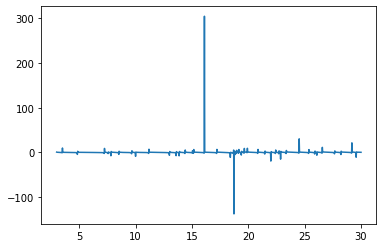

In [124]:
plot(lambds,integs)

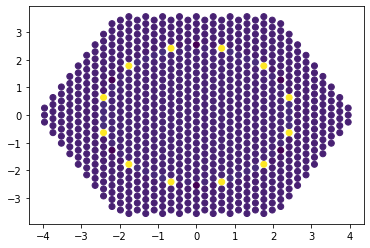

In [125]:
scatter(KX,KY,c=Sf(KX,KY,3,0.1))